In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
names = ['one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'eleven',
         'twelve', 'thirteen', 'fourteen', 'fifteen', 'sixteen']
number_of_layers = 12 #np.random.randint(0,15)
neighbors = np.random.randint(1,200)
df =  pd.DataFrame()
    
for j in np.arange(3,5.5,0.1):
    rolling = pd.DataFrame()
    rolling['zero'] = 3*np.sin(np.arange(0,20,0.1)/6.28)
    for i in range(len(names[0:number_of_layers])):
        layer_elevation = 3*np.sin(np.arange(0,20,0.1)/6.28)+np.random.uniform(0,i)
        elevation = np.full(200, j)
        layer_elevation = np.where(layer_elevation > elevation, elevation, layer_elevation)
        rolling[names[i]] = layer_elevation
    df = pd.concat((df, rolling))
angular_thicknesses = df.T.diff(axis=0).abs().T
neigh = angular_thicknesses.shift(neighbors)
logged = angular_thicknesses.apply(np.log)
powered= angular_thicknesses.apply(lambda x: x**10)
angular_thicknesses = pd.concat([angular_thicknesses, neigh, logged, powered], axis=1, join_axes=[angular_thicknesses.index]
                               ).drop(columns=['zero']).dropna().replace(-np.inf, 0)

#now for onlap section
df_onlap =  pd.DataFrame()
    
for j in np.arange(3,5.5,0.1):
    rolling = pd.DataFrame()
    rolling['zero'] = 3*np.sin(np.arange(0,20,0.1)/6.28)
    for i in range(len(names[0:number_of_layers])):
        zero = 3*np.sin(np.arange(0,20,0.1)/6.28)
        randomness = np.random.uniform(0,i)
        elevation = np.full(200, j)
        onlap = np.where(np.full(200,randomness) > zero, np.full(200,randomness), zero)
        layer_elevation = np.where( onlap > elevation, elevation,  onlap)
        rolling[names[i]] = layer_elevation
    df_onlap = pd.concat((df, rolling))
onlap_thicknesses = df_onlap.T.diff(axis=0).abs().T
neigh = onlap_thicknesses.shift(neighbors)
logged = onlap_thicknesses.apply(np.log)
powered= onlap_thicknesses.apply(lambda x: x**10)
onlap_thicknesses = pd.concat([onlap_thicknesses, neigh, logged, powered], axis=1, join_axes=[onlap_thicknesses.index]
                               ).drop(columns=['zero']).dropna().replace(-np.inf, 0)

#now for horizontal stratification

df_horizontal =  pd.DataFrame()
    
for j in np.arange(3, 5.5,0.1):
    rolling = pd.DataFrame()
    rolling['zero'] = np.full(200, 0)-np.random.rand(200)/10
    for i in range(len(names[0:number_of_layers])):
        randomness = np.random.uniform(0,i)
        rolling[names[i]] = np.full(200, randomness)+np.random.rand(200)/100
    df_horizontal = pd.concat((df, rolling))
horizontal_thicknesses = df_horizontal.T.diff(axis=0).abs().T
neigh = horizontal_thicknesses.shift(neighbors)
logged = horizontal_thicknesses.apply(np.log)
powered= horizontal_thicknesses.apply(lambda x: x**10)

horizontal_thicknesses = pd.concat([horizontal_thicknesses, neigh, logged, powered], axis=1, join_axes=[horizontal_thicknesses.index]
                               ).drop(columns=['zero']).dropna().replace(-np.inf, 0)

#normalize the data
normalized_df=(angular_thicknesses-angular_thicknesses.min())/(angular_thicknesses.max()-angular_thicknesses.min()).replace(0,0.00001)
normalized_dfo=(onlap_thicknesses-onlap_thicknesses.min())/(onlap_thicknesses.max()-onlap_thicknesses.min()).replace(0,0.00001)
normalized_dfh=(horizontal_thicknesses-horizontal_thicknesses.min())/(horizontal_thicknesses.max()-horizontal_thicknesses.min()).replace(0,0.00001)
normalized_dfo['class'] = 1
normalized_df['class'] = 0
normalized_dfh['class'] = 2

#merge into new dataset
dataset = pd.concat((normalized_df, normalized_dfo, normalized_dfh))


In [3]:
dataset.columns

Index(['one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine',
       'ten', 'eleven', 'twelve', 'one', 'two', 'three', 'four', 'five', 'six',
       'seven', 'eight', 'nine', 'ten', 'eleven', 'twelve', 'one', 'two',
       'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten',
       'eleven', 'twelve', 'one', 'two', 'three', 'four', 'five', 'six',
       'seven', 'eight', 'nine', 'ten', 'eleven', 'twelve', 'class'],
      dtype='object')

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataset.iloc[0:, 0:-1].values, dataset.iloc[0:,-1].values, test_size=0.4, random_state=86)
#X_train_rand, X_test_rand, y_train_rand, y_test_rand =train_test_split(randomData[0:,0:7], randomData[0:,7], test_size=0.2, random_state=86)

In [5]:
from keras.utils import to_categorical
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

y_train_rand_encoded = to_categorical(np.random.randint(0,3, 11357))
y_test_rand_encoded = to_categorical(np.random.randint(0,3, 2840))

C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv1D

In [7]:
model = Sequential()
model.add(Dense(100, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, kernel_initializer='random_uniform', activation='sigmoid'))

In [8]:
model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['categorical_accuracy'])

In [9]:
model.fit(X_train, y_train_encoded, epochs=100, batch_size=32)

Epoch 1/100
8995/8995 [==============================] - 1s 79us/step - loss: 0.6421 - categorical_accuracy: 0.6570
Epoch 2/100
8995/8995 [==============================] - 0s 52us/step - loss: 0.4467 - categorical_accuracy: 0.7352
Epoch 3/100
8995/8995 [==============================] - 0s 50us/step - loss: 0.4164 - categorical_accuracy: 0.7616
Epoch 4/100
8995/8995 [==============================] - 0s 48us/step - loss: 0.3983 - categorical_accuracy: 0.7807
Epoch 5/100
8995/8995 [==============================] - 0s 49us/step - loss: 0.3752 - categorical_accuracy: 0.7962
Epoch 6/100
8995/8995 [==============================] - 0s 49us/step - loss: 0.3617 - categorical_accuracy: 0.8010
Epoch 7/100
8995/8995 [==============================] - 0s 48us/step - loss: 0.3411 - categorical_accuracy: 0.8207
Epoch 8/100
8995/8995 [==============================] - 0s 48us/step - loss: 0.3277 - categorical_accuracy: 0.8282 0s - loss: 0.3290 - categorical_accuracy: 0.82
Epoch 9/100
8995/8995 [==

8995/8995 [==============================] - 0s 49us/step - loss: 0.0993 - categorical_accuracy: 0.9580
Epoch 71/100
8995/8995 [==============================] - 0s 46us/step - loss: 0.0961 - categorical_accuracy: 0.9611
Epoch 72/100
8995/8995 [==============================] - 0s 49us/step - loss: 0.1072 - categorical_accuracy: 0.9553
Epoch 73/100
8995/8995 [==============================] - 0s 46us/step - loss: 0.0994 - categorical_accuracy: 0.9609
Epoch 74/100
8995/8995 [==============================] - 0s 47us/step - loss: 0.0945 - categorical_accuracy: 0.9630
Epoch 75/100
8995/8995 [==============================] - 0s 50us/step - loss: 0.0994 - categorical_accuracy: 0.9581
Epoch 76/100
8995/8995 [==============================] - 0s 49us/step - loss: 0.0935 - categorical_accuracy: 0.9626
Epoch 77/100
8995/8995 [==============================] - 0s 50us/step - loss: 0.0908 - categorical_accuracy: 0.9630
Epoch 78/100
8995/8995 [==============================] - 0s 48us/step - loss

In [10]:
score=model.evaluate(X_test, y_test_encoded)
score

5997/5997 [==============================] - 0s 37us/step


[0.044374184223282966, 0.991162247790562]

In [11]:
preds = model.predict(X_test)

C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


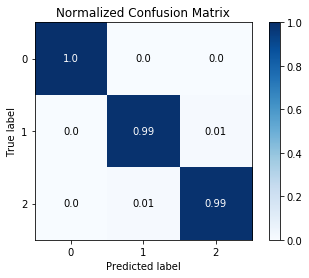

In [12]:
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y_test, np.argmax(preds, axis=1), normalize=True)

In [13]:
tops = pd.read_csv(r'D:\topsexport05292018.csv')

In [14]:
tops2 = tops.pivot_table('depth', 'formation', 'api').fillna(0).T
tops2.columns

Index(['BELLE_FOURCHE', 'FOX_HILLS', 'GAMMON', 'GREENHORN',
       'MITTEN_BLACK_SHALE', 'MOWRY', 'MUDDY', 'NIOBRARA', 'PARKMAN_BASE',
       'PARKMAN_TOP', 'PIERRE', 'POOL_CREEK', 'RED_BIRD', 'SAGE_BREAKS',
       'TEAPOT_BASE', 'TEAPOT_TOP', 'TECKLA_BASE', 'TECKLA_TOP', 'TURNER',
       'WALL_CREEK'],
      dtype='object', name='formation')

In [15]:
tops2 = tops2[['MUDDY', 'MOWRY', 'BELLE_FOURCHE', 'GREENHORN',  'NIOBRARA', 'PARKMAN_BASE', 'PARKMAN_TOP',
               'TECKLA_BASE', 'TECKLA_TOP','TEAPOT_BASE', 'TEAPOT_TOP', 'PIERRE', 'FOX_HILLS' ]]

In [16]:
tops3 = tops2.diff(axis=1).abs().drop(columns=['MUDDY']).dropna()

In [17]:
neigh = tops3.shift(10)
logged = tops3.apply(np.log)
powered= tops3.apply(lambda x: x**10)
tops3 = pd.concat([tops3, neigh, logged, powered], axis=1, join_axes=[tops3.index]
                               ).dropna().replace(-np.inf, 0)

In [18]:
normalized_tops3=(tops3-tops3.min())/(tops3.max()-tops3.min()).replace(0,0.00001)
real_data = normalized_tops3.values

In [19]:
well_preds = model.predict(real_data)

In [20]:
predictions = np.argmax(well_preds, axis=1)

(array([ 2.,  0.,  0.,  0.,  0., 85.,  0.,  0.,  0.,  7.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

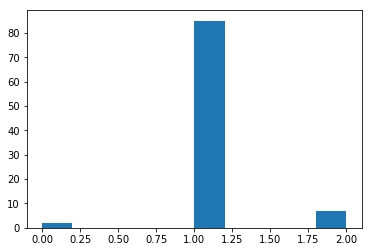

In [21]:
plt.hist(predictions)